# Image-to-image transition between pipelines using StarGAN

We used [StarGAN](https://arxiv.org/abs/1711.09020), a Generative Adversarial Network for multi-domain image-to-image transition, to convert fMRI statistic maps from one pipeline to another. 

The dataset used in this study was the [HCP multi-pipeline dataset](https://arxiv.org/abs/2312.14493), which contain subject-level and group-level statistic maps for 24 pipelines and more than 1,000 individuals. 

We selected 4 pipelines based on a [previous study](https://arxiv.org/abs/2312.06231) and study the ability of StarGAN to transfer images between the pipelines. 

In [13]:
from utils.datasets import ImageDataset
from results import metrics
from torch.utils.data import DataLoader
from glob import glob
from scipy import stats
from statannotations.Annotator import Annotator
from results import denorm
from nilearn import plotting 
from nilearn.plotting.cm import _cmap_d as nilearn_cmaps

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

import sys 
import importlib
import torch
import os
import random

In [14]:
sample_dir = './stargan/samples'

## Evaluation metrics

### Correlations

In [15]:
p_source_list = np.unique(
    [f.split('_')[-2][5:] for f in sorted(
        glob(
            f'{sample_dir}/trg_img-*_orig-*_target-*.nii.gz'
        )
    )
    ]
)
p_target_list = np.unique(
    [f.split('_')[-1].split('.')[0][7:] for f in sorted(
        glob(
            f'{sample_dir}/trg_img-*_orig-*_target-*.nii.gz'
        )
    )
    ]
)

In [12]:
for p_source in p_source_list:
    for p_target in p_target_list:
        
        if not os.path.exists(f'./stargan/metrics/correlations-{p_source}-{p_target}.csv'):
    
            data_trg = sorted(
                glob(
                    f'{sample_dir}/trg_img-*_orig-{p_source}_target-{p_target}.nii.gz'
                )
            )[:50]
            
            data_gen = sorted(
                glob(
                    f'{sample_dir}/gen_img-*_orig-{p_source}_target-{p_target}.nii.gz'
                )
            )[:50]
            
            data_src = sorted(
                glob(
                    f'{sample_dir}/src_img-*_orig-{p_source}_target-{p_target}.nii.gz'
                )
            )[:50]
            
            corr_s_t = []
            corr_g_t = []
            
            for i in range(len(data_gen)):
                # Source - Target correlations
                corr_s_t.append(
                    metrics.get_correlation(
                        nib.load(data_src[i]), 
                        nib.load(data_trg[i])
                    )
                )
            
                # Generated - Target correlations
                corr_g_t.append(
                    metrics.get_correlation(
                        nib.load(data_trg[i]), 
                        nib.load(data_gen[i])
                    )
                )
            
            df_st = pd.DataFrame(
                {'Type' :['Source-Target' for i in range(len(corr_s_t))],
                 'Correlation' : corr_s_t}
            )
            
            df_tg = pd.DataFrame(
                {'Type' :['Target-Generated' for i in range(len(corr_g_t))],
                 'Correlation' : corr_g_t}
            )
            
            df = pd.concat([df_st, df_tg])
            
            df.to_csv(f'./stargan/metrics/correlations-{p_source}-{p_target}.csv')

In [16]:
for i, p_source in enumerate(p_source_list):
    for j, p_target in enumerate(p_target_list):
        df = pd.read_csv(f'./stargan/metrics/correlations-{p_source}-{p_target}.csv')
        
        print(i, '->', j)
        print('Source-Target', round(np.mean(df['Correlation'].loc[df['Type']=='Source-Target'].iloc[:50])*100,1))
        print('Target-Generated', round(np.mean(df['Correlation'].loc[df['Type']=='Target-Generated'].iloc[:50])*100,1))

0 -> 0
Source-Target 100.0
Target-Generated 92.3
0 -> 1
Source-Target 92.0
Target-Generated 89.8
0 -> 2
Source-Target 85.7
Target-Generated 91.3
0 -> 3
Source-Target 78.5
Target-Generated 86.8
1 -> 0
Source-Target 92.0
Target-Generated 91.6
1 -> 1
Source-Target 100.0
Target-Generated 91.7
1 -> 2
Source-Target 77.4
Target-Generated 90.5
1 -> 3
Source-Target 82.6
Target-Generated 87.5
2 -> 0
Source-Target 85.7
Target-Generated 90.0
2 -> 1
Source-Target 77.4
Target-Generated 87.0
2 -> 2
Source-Target 100.0
Target-Generated 93.6
2 -> 3
Source-Target 92.7
Target-Generated 90.3
3 -> 0
Source-Target 78.6
Target-Generated 89.3
3 -> 1
Source-Target 82.6
Target-Generated 87.5
3 -> 2
Source-Target 92.7
Target-Generated 92.5
3 -> 3
Source-Target 100.0
Target-Generated 91.0


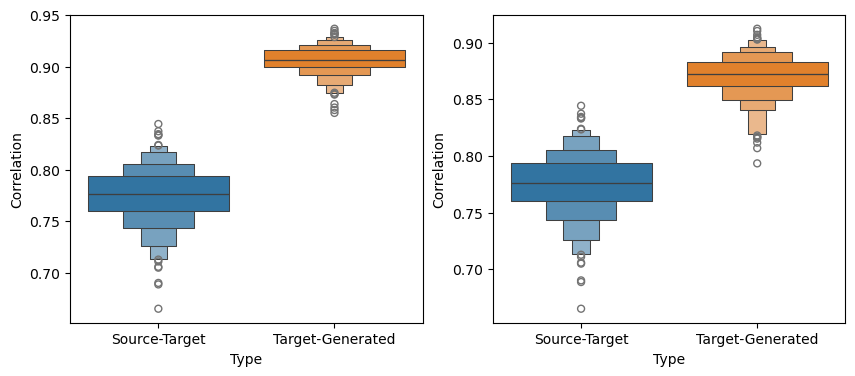

In [8]:
f, ax = plt.subplots(
        1,2, 
        figsize = (10,4)
    )

p_target = 'spm-5-0-0'
p_source = 'fsl-5-0-1'

df = pd.read_csv(f'./stargan/metrics/correlations-{p_source}-{p_target}.csv')

b = sns.boxenplot(
    x = df['Type'], 
    y = df['Correlation'], 
    hue=df['Type'],
    ax=ax[0] 
)

# pairs = [('Source-Target', 'Target-Generated')]
# annotator = Annotator(
#     pairs = pairs, 
#     ax=ax[0], 
#     x=df['Type'], 
#     y=df['Correlation'], 
#     palette="husl"
# )

# annotator.configure(test='Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()

p_target = 'fsl-5-0-1'
p_source = 'spm-5-0-0'

df = pd.read_csv(f'./stargan/metrics/correlations-{p_source}-{p_target}.csv')

b = sns.boxenplot(
    x = df['Type'], 
    y = df['Correlation'], 
    hue=df['Type'],
    ax=ax[1] 
)

# pairs = [('Source-Target', 'Target-Generated')]
# annotator = Annotator(
#     pairs = pairs, 
#     ax=ax[1], 
#     x=df['Type'], 
#     y=df['Correlation'], 
#     palette="husl"
# )

# annotator.configure(test='Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()

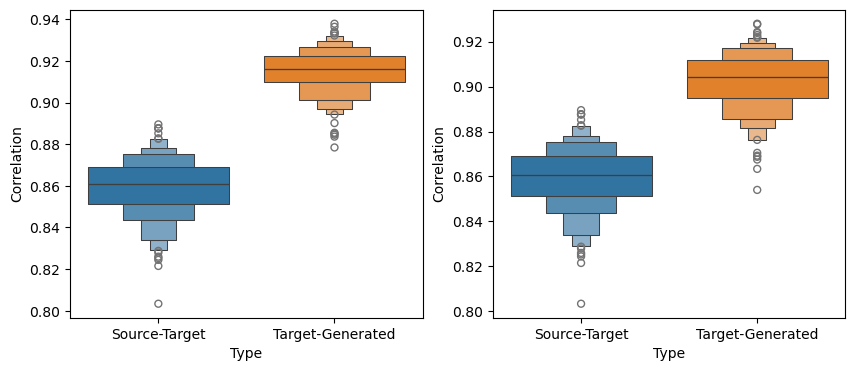

In [9]:
f, ax = plt.subplots(
        1,2, 
        figsize = (10,4)
    )

p_target = 'spm-5-0-0'
p_source = 'fsl-5-0-0'

df = pd.read_csv(f'./stargan/metrics/correlations-{p_source}-{p_target}.csv')

b = sns.boxenplot(
    x = df['Type'], 
    y = df['Correlation'], 
    hue=df['Type'],
    ax=ax[0] 
)

# pairs = [('Source-Target', 'Target-Generated')]
# annotator = Annotator(
#     pairs = pairs, 
#     ax=ax[0], 
#     x=df['Type'], 
#     y=df['Correlation'], 
#     palette="husl"
# )

# annotator.configure(test='Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()

p_target = 'fsl-5-0-0'
p_source = 'spm-5-0-0'

df = pd.read_csv(f'./stargan/metrics/correlations-{p_source}-{p_target}.csv')

b = sns.boxenplot(
    x = df['Type'], 
    y = df['Correlation'], 
    hue=df['Type'],
    ax=ax[1] 
)

# pairs = [('Source-Target', 'Target-Generated')]
# annotator = Annotator(
#     pairs = pairs, 
#     ax=ax[1], 
#     x=df['Type'], 
#     y=df['Correlation'], 
#     palette="husl"
# )

# annotator.configure(test='Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()

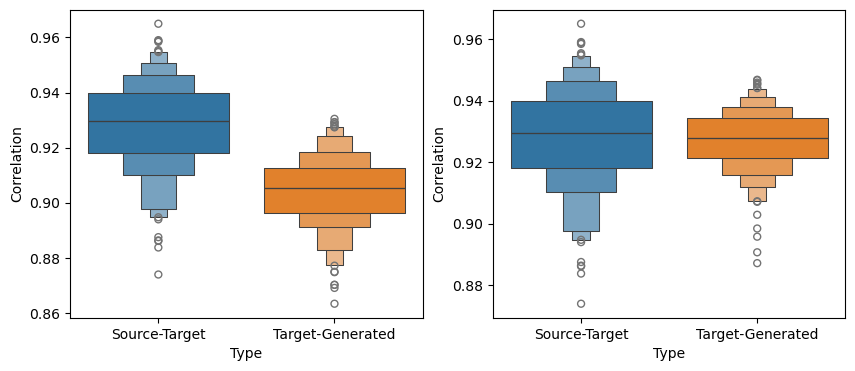

In [10]:
f, ax = plt.subplots(
        1,2, 
        figsize = (10,4)
    )

p_target = 'spm-5-0-1'
p_source = 'spm-5-0-0'

df = pd.read_csv(f'./stargan/metrics/correlations-{p_source}-{p_target}.csv')

b = sns.boxenplot(
    x = df['Type'], 
    y = df['Correlation'], 
    hue=df['Type'],
    ax=ax[0] 
)

# pairs = [('Source-Target', 'Target-Generated')]
# annotator = Annotator(
#     pairs = pairs, 
#     ax=ax[0], 
#     x=df['Type'], 
#     y=df['Correlation'], 
#     palette="husl"
# )

# annotator.configure(test='Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()

p_target = 'spm-5-0-0'
p_source = 'spm-5-0-1'

df = pd.read_csv(f'./stargan/metrics/correlations-{p_source}-{p_target}.csv')

b = sns.boxenplot(
    x = df['Type'], 
    y = df['Correlation'], 
    hue=df['Type'],
    ax=ax[1] 
)

# pairs = [('Source-Target', 'Target-Generated')]
# annotator = Annotator(
#     pairs = pairs, 
#     ax=ax[1], 
#     x=df['Type'], 
#     y=df['Correlation'], 
#     palette="husl"
# )

# annotator.configure(test='Mann-Whitney', text_format='star')
# annotator.apply_and_annotate()

### PSNR

In [21]:
for p_source in p_source_list:
    for p_target in p_target_list:
        
        if not os.path.exists(f'./stargan/metrics/psnr-{p_source}-{p_target}.csv'):
    
            data_trg = sorted(
                glob(
                    f'{sample_dir}/trg_img-*_orig-{p_source}_target-{p_target}.nii.gz'
                )
            )
            trg_dataset = ImageDataset(data_trg)
            trg_loader = DataLoader(
                trg_dataset, 
                batch_size=1,
                shuffle=False)
            
            data_gen = sorted(
                glob(
                    f'{sample_dir}/gen_img-*_orig-{p_source}_target-{p_target}.nii.gz'
                )
            )
            gen_dataset = ImageDataset(data_gen)
            gen_loader = DataLoader(
                gen_dataset, 
                batch_size=1,
                shuffle=False)
            
            data_src = sorted(
                glob(
                    f'{sample_dir}/src_img-*_orig-{p_source}_target-{p_target}.nii.gz'
                )
            )
            src_dataset = ImageDataset(data_src)
            src_loader = DataLoader(
                src_dataset, 
                batch_size=1,
                shuffle=False)
            
            # Source - Target PSNR
            psnr_s_t = []
            
            for data1, data2 in zip(trg_loader, src_loader):
                psnr_s_t.append(
                    metrics.PSNR(
                        data1.detach().numpy(), 
                        data2.detach().numpy()
                    )
                )
            
            # Source - Target PSNR
            psnr_g_t = []
            
            for data1, data2 in zip(trg_loader, gen_loader):
                psnr_g_t.append(
                    metrics.PSNR(
                        data1.detach().numpy(), 
                        data2.detach().numpy()
                    )
                )
            
            df_st = pd.DataFrame(
                {'Type' :['Source-Target' for i in range(len(psnr_s_t))],
                 'PSNR' : psnr_s_t}
            )
            
            df_tg = pd.DataFrame(
                {'Type' :['Target-Generated' for i in range(len(psnr_g_t))],
                 'PSNR' : psnr_g_t}
            )
            
            df = pd.concat([df_st, df_tg])
            
            df.to_csv(f'./stargan/metrics/psnr-{p_source}-{p_target}.csv')

In [24]:
for p_source in p_source_list:
    for p_target in p_target_list:
        df = pd.read_csv(f'./stargan/metrics/psnr-{p_source}-{p_target}.csv')
        
        print(p_source, '->', p_target)
        print('Source-Target', round(np.mean(df['PSNR'].loc[df['Type']=='Source-Target']),2))
        print('Target-Generated', round(np.mean(df['PSNR'].loc[df['Type']=='Target-Generated']),2))

fsl-5-0-0 -> fsl-5-0-0
Source-Target 100.0
Target-Generated 86.09
fsl-5-0-0 -> fsl-5-0-1
Source-Target 83.99
Target-Generated 85.43
fsl-5-0-0 -> spm-5-0-0
Source-Target 80.9
Target-Generated 82.95
fsl-5-0-0 -> spm-5-0-1
Source-Target 79.56
Target-Generated 82.3
fsl-5-0-1 -> fsl-5-0-0
Source-Target 83.99
Target-Generated 85.25
fsl-5-0-1 -> fsl-5-0-1
Source-Target 100.0
Target-Generated 85.08
fsl-5-0-1 -> spm-5-0-0
Source-Target 78.38
Target-Generated 82.12
fsl-5-0-1 -> spm-5-0-1
Source-Target 81.24
Target-Generated 81.91
spm-5-0-0 -> fsl-5-0-0
Source-Target 80.9
Target-Generated 85.07
spm-5-0-0 -> fsl-5-0-1
Source-Target 78.38
Target-Generated 84.25
spm-5-0-0 -> spm-5-0-0
Source-Target 100.0
Target-Generated 84.12
spm-5-0-0 -> spm-5-0-1
Source-Target 81.27
Target-Generated 83.36
spm-5-0-1 -> fsl-5-0-0
Source-Target 79.56
Target-Generated 84.25
spm-5-0-1 -> fsl-5-0-1
Source-Target 81.24
Target-Generated 83.36
spm-5-0-1 -> spm-5-0-0
Source-Target 81.27
Target-Generated 82.71
spm-5-0-1 -> 

/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and w

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Source-Target vs. Target-Generated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.479e-74 U_stat=4.000e+04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Source-Target vs. Target-Generated: Mann-Whitney-Wilcoxon test two-sided, P_val:2.495e-71 U_stat=4.000e+04
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Source-Target vs. Target-Generated: Mann-Whitney-Wilcoxon test two-sided, P_val:1.805e-73 U_stat=4.000e+04


/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/seaborn/categorical.py:1794: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/egermani/miniforge3/envs/workEnv/lib/python3.10/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Source-Target vs. Target-Generated: Mann-Whitney-Wilcoxon test two-sided, P_val:6.941e-76 U_stat=4.000e+04


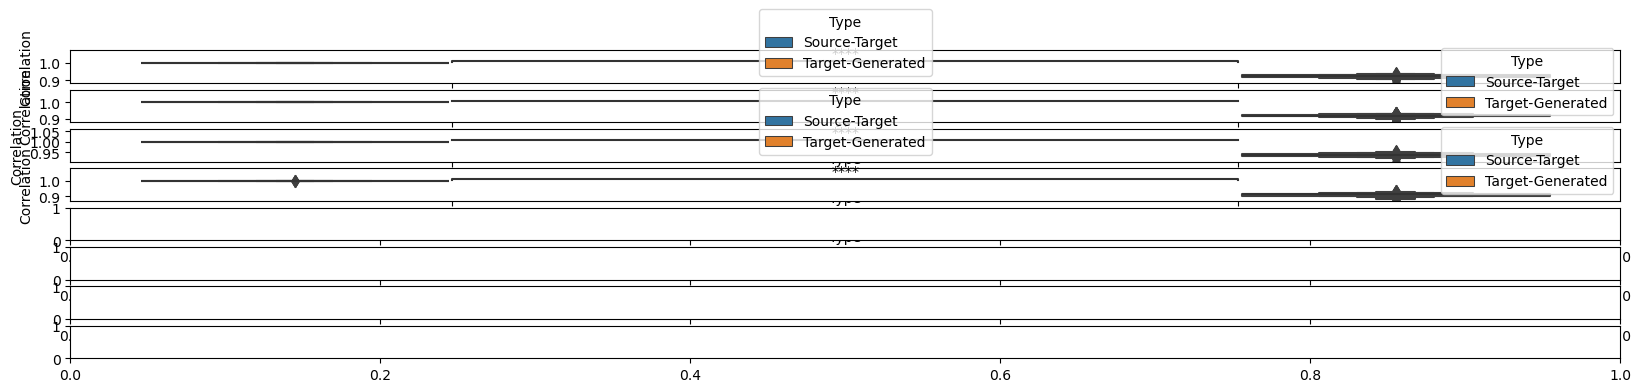

In [35]:
f, ax = plt.subplots(
        4,4, 
        figsize = (20,4)
    )

for i, p_source in p_source_list:
    for j, p_target in p_target_list:
    
        if p_source == p_target:
            pass
            
        df = pd.read_csv(f'./stargan/metrics/psnr-{p_source}-{p_target}.csv')
        
        b = sns.boxenplot(
            x = df['Type'], 
            y = df['Correlation'], 
            hue=df['Type'],
            ax=ax[i,j] 
        )
        
        pairs = [('Source-Target', 'Target-Generated')]
        annotator = Annotator(
            pairs = pairs, 
            ax=ax[i], 
            x=df['Type'], 
            y=df['PSNR'], 
            palette="husl"
        )
        
        annotator.configure(test='Mann-Whitney', text_format='star')
        annotator.apply_and_annotate()

### SSIM

In [34]:
import torch
from torchmetrics.image import StructuralSimilarityIndexMeasure

ssim = StructuralSimilarityIndexMeasure(data_range=1.0)

for p_source in p_source_list:
    for p_target in p_target_list:

        if not os.path.exists(f'./stargan/metrics/ssim-{p_source}-{p_target}.csv'):
    
            data_trg = sorted(
                glob(
                    f'{sample_dir}/trg_img-*_orig-{p_source}_target-{p_target}.nii.gz'
                )
            )
            trg_dataset = ImageDataset(data_trg)
            trg_loader = DataLoader(
                trg_dataset, 
                batch_size=1,
                shuffle=False)
            
            data_gen = sorted(
                glob(
                    f'{sample_dir}/gen_img-*_orig-{p_source}_target-{p_target}.nii.gz'
                )
            )
            gen_dataset = ImageDataset(data_gen)
            gen_loader = DataLoader(
                gen_dataset, 
                batch_size=1,
                shuffle=False)
            
            data_src = sorted(
                glob(
                    f'{sample_dir}/src_img-*_orig-{p_source}_target-{p_target}.nii.gz'
                )
            )
            src_dataset = ImageDataset(data_src)
            src_loader = DataLoader(
                src_dataset, 
                batch_size=1,
                shuffle=False)
            
            # Source - Target SSIM
            ssim_s_t = []
            
            for data1, data2 in zip(trg_loader, src_loader):
                ssim_s_t.append(
                    ssim(
                        data1, 
                        data2
                    ).detach().numpy()
                )
            
            # Source - Target SSIM
            ssim_g_t = []
            
            for data1, data2 in zip(trg_loader, gen_loader):
                ssim_g_t.append(
                    ssim(
                        data1, 
                        data2
                    ).detach().numpy()
                )
            
            df_st = pd.DataFrame(
                {'Type' :['Source-Target' for i in range(len(ssim_s_t))], 
                 'SSIM' : ssim_s_t}
            )
            
            df_tg = pd.DataFrame(
                {'Type' :['Target-Generated' for i in range(len(ssim_g_t))], 
                 'SSIM' : ssim_g_t}
            )
    
            df = pd.concat([df_st, df_tg])
            
            df.to_csv(f'./stargan/metrics/ssim-{p_source}-{p_target}.csv')

In [36]:
for p_source in p_source_list:
    for p_target in p_target_list:
        df = pd.read_csv(f'./stargan/metrics/ssim-{p_source}-{p_target}.csv')
        
        print(p_source, '->', p_target)
        print('Source-Target', round(np.mean(df['SSIM'].loc[df['Type']=='Source-Target']),2))
        print('Target-Generated', round(np.mean(df['SSIM'].loc[df['Type']=='Target-Generated']),2))

fsl-5-0-0 -> fsl-5-0-0
Source-Target 1.0
Target-Generated 0.91
fsl-5-0-0 -> fsl-5-0-1
Source-Target 0.83
Target-Generated 0.89
fsl-5-0-0 -> spm-5-0-0
Source-Target 0.83
Target-Generated 0.88
fsl-5-0-0 -> spm-5-0-1
Source-Target 0.75
Target-Generated 0.85
fsl-5-0-1 -> fsl-5-0-0
Source-Target 0.83
Target-Generated 0.88
fsl-5-0-1 -> fsl-5-0-1
Source-Target 1.0
Target-Generated 0.87
fsl-5-0-1 -> spm-5-0-0
Source-Target 0.75
Target-Generated 0.86
fsl-5-0-1 -> spm-5-0-1
Source-Target 0.82
Target-Generated 0.85
spm-5-0-0 -> fsl-5-0-0
Source-Target 0.83
Target-Generated 0.88
spm-5-0-0 -> fsl-5-0-1
Source-Target 0.75
Target-Generated 0.86
spm-5-0-0 -> spm-5-0-0
Source-Target 1.0
Target-Generated 0.91
spm-5-0-0 -> spm-5-0-1
Source-Target 0.81
Target-Generated 0.88
spm-5-0-1 -> fsl-5-0-0
Source-Target 0.75
Target-Generated 0.85
spm-5-0-1 -> fsl-5-0-1
Source-Target 0.82
Target-Generated 0.83
spm-5-0-1 -> spm-5-0-0
Source-Target 0.81
Target-Generated 0.87
spm-5-0-1 -> spm-5-0-1
Source-Target 1.0
Ta

### Class change

In [42]:
model_param = './style_transfer/feature_extractor/models/model_b-64_lr-1e-04_epochs_100.pth'

class_trg = []
class_gen = []

for data in trg_loader:
    class_trg.append(
        metrics.class_change(model_param, data.float()))

for data in gen_loader:
    class_gen.append(
        metrics.class_change(model_param, data.float()))

/Users/egermani/Documents/style_transfer/./feature_extractor/model.py:82: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = self.softmax(x)


In [43]:
print(class_trg == class_gen)

True


### Inception Score
This score estimates the quality of a collection of synthetic images based on how well the top-performing classification model classifies them as one of the pipelines. The scores combine both the confidence of the conditional class predictions for each synthetic image (quality) and the integral of the marginal probability of the predicted classes (diversity).
*Images that contain meaningful objects should have a conditional label distribution p(y|x) with low entropy.*

The entropy is calculated as the negative sum of each observed probability multiplied by the log of the probability. The intuition here is that large probabilities have less information than small probabilities.
entropy = -sum(p_i * log(p_i))

To capture our interest in a variety of images, we use the marginal probability. This is the probability distribution of all generated images. We, therefore, would prefer the integral of the marginal probability distribution to have a high entropy.
*Moreover, we expect the model to generate varied images, so the marginal integral p(y|x = G(z))dz should have high entropy.*

— Improved Techniques for Training GANs, 2016.

These elements are combined by calculating the Kullback-Leibler divergence, or KL divergence (relative entropy), between the conditional and marginal probability distributions.

Calculating the divergence between two distributions is written using the “||” operator, therefore we can say we are interested in the KL divergence between C for conditional and M for marginal distributions or:

KL (C || M)
Specifically, we are interested in the average of the KL divergence for all generated images.

Combining these two requirements, the metric that we propose is: exp(Ex KL(p(y|x)||p(y))).

In [ ]:
import sys 
import importlib
import torch

model_param = './style_transfer/feature_extractor/models/model_b-64_lr-1e-04_epochs_100.pth'

sys.path.insert(0, './feature_extractor')
package = 'model'
md = importlib.import_module(package)

classifier = torch.load(model_param, map_location='cpu')

data_trg = sorted(glob(f'{sample_dir}/trg_img-*_orig-*_target-*.nii.gz'))
trg_dataset = ImageDataset(data_trg)
trg_loader = DataLoader(
    trg_dataset, 
    batch_size=10,
    shuffle=False)

data_gen = sorted(glob(f'{sample_dir}/gen_img-*_orig-*_target-*.nii.gz'))
gen_dataset = ImageDataset(data_gen)
gen_loader = DataLoader(
    gen_dataset, 
    batch_size=10,
    shuffle=False)

data_src = sorted(glob(f'{sample_dir}/src_img-*_orig-*_target-*.nii.gz'))
src_dataset = ImageDataset(data_src)
src_loader = DataLoader(
    src_dataset, 
    batch_size=10,
    shuffle=False)

is_gen = []

for data in gen_loader:
    act = classifier(data.float().to('cpu'))
    is_gen.append(metrics.get_inception_score(act.detach().numpy()))

is_trg = []

for data in trg_loader:
    act = classifier(data.float().to('cpu'))
    is_trg.append(metrics.get_inception_score(act.detach().numpy()))

df = pd.DataFrame({'Target inception score':[f'{np.mean(is_trg)} ({np.std(is_trg)})'],
                   'Generated inception score':[f'{np.mean(is_gen)} ({np.std(is_gen)})']})

In [66]:
print('Inception score TARGET:', np.mean(is_trg), '(', np.std(is_trg), ')')
print('Inception score GENERATED:', np.mean(is_gen), '(', np.std(is_gen), ')')

Inception score TARGET: 2.0000086 ( 4.899699e-05 )
Inception score GENERATED: 2.0014367 ( 0.0035125648 )


### Visualization

In [32]:
# Back to original data (not normalized)
df_test_img = pd.read_csv('./data/test-dataset_rh_4classes.csv')
group_list = sorted(np.unique(df_test_img['groups']).tolist())

src_img_list = [f'/Volumes/egermani/hcp_many_pipelines_preprocess/resampled-masked/group-{g}_right-hand_{p_source}_con.nii' \
                for g in group_list]
trg_img_list = [f'/Volumes/egermani/hcp_many_pipelines_preprocess/resampled-masked/group-{g}_right-hand_{p_target}_con.nii' \
                for g in group_list]

gen_img_list = sorted(glob(f'{sample_dir}/gen*_orig-{p_source}_target-{p_target}.nii.gz'))

if not os.path.isdir(f'./stargan/samples-denorm'):
    os.mkdir(f'./stargan/samples-denorm')

for i, gen in enumerate(gen_img_list):
    img_name = gen.split('/')[-1]
    src = src_img_list[i]

    src_img = nib.load(src)
    gen_img = nib.load(gen)

    gen_denorm_img = denorm.un_normalize(gen_img, src_img, scaling=100 * 0.4)

    nib.save(gen_denorm_img, f'./stargan/samples-denorm/{img_name}')

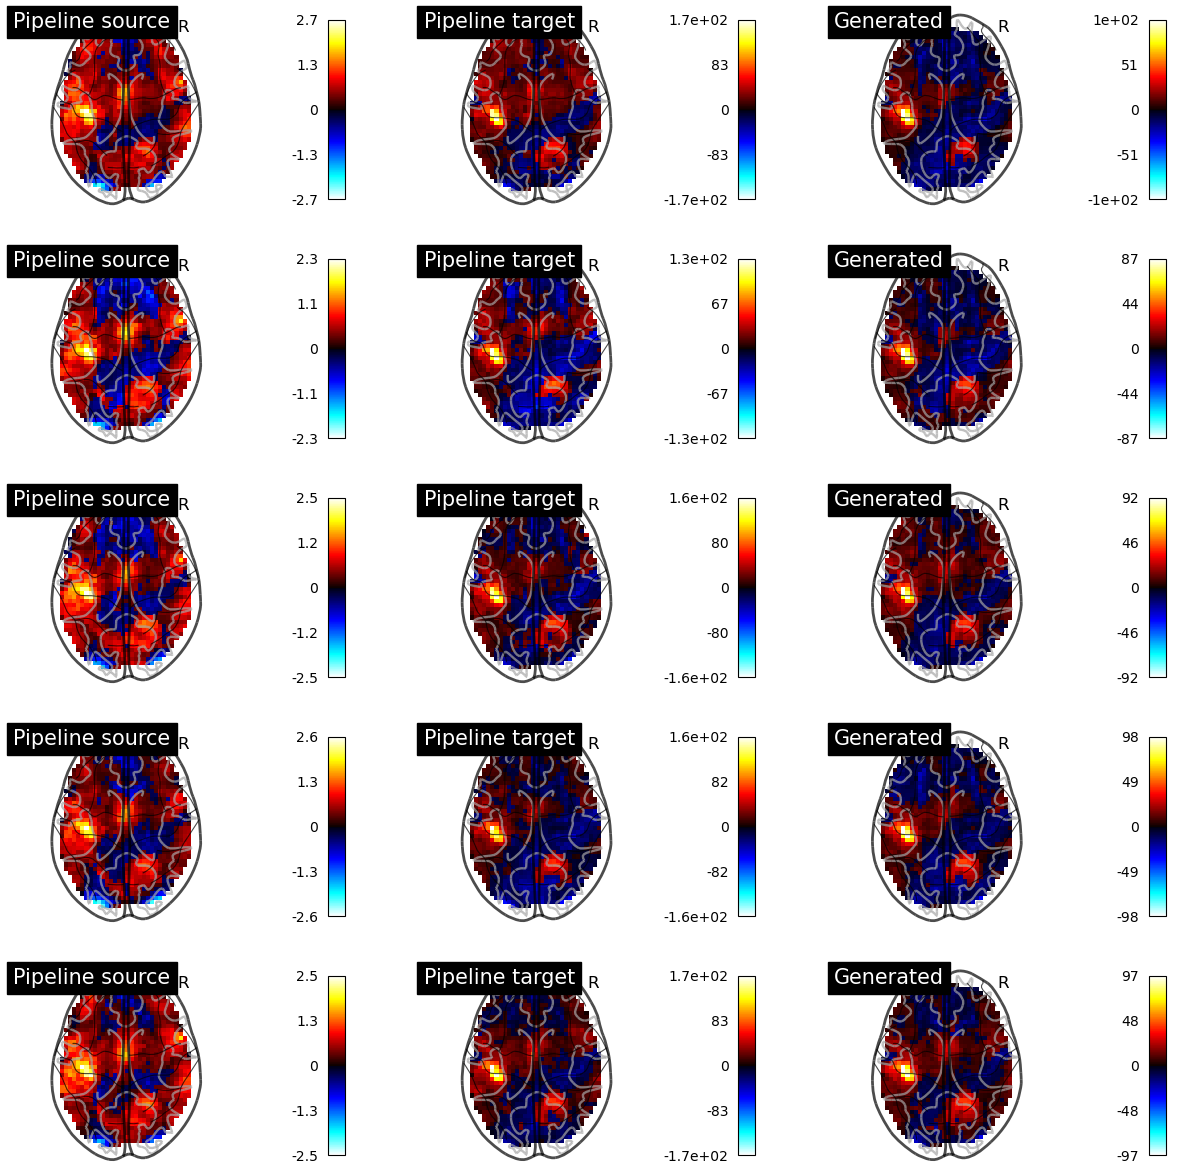

In [34]:
denorm_gen_img_list = sorted(glob(f'./stargan/samples-denorm/gen*_orig-{p_source}_target-{p_target}.nii.gz'))
grp_sample = random.sample(range(len(group_list)), 5)

p_val = 0.001
p001_unc = stats.norm.isf(p_val)

f,ax = plt.subplots(5,3, figsize=(15, 15))

for i, grp in enumerate(grp_sample):
    # Init
    display = plotting.plot_glass_brain(
        src_img_list[grp],
        colorbar=True,
        cmap=nilearn_cmaps['cold_hot'],
        plot_abs=False,
        title="Pipeline source",
        display_mode='z',
        figure=f, axes=ax[i,0]
    )
    
    # Ground truth
    display = plotting.plot_glass_brain(
        trg_img_list[grp],
        colorbar=True,
        cmap=nilearn_cmaps['cold_hot'],
        plot_abs=False,
        title="Pipeline target",
        display_mode='z',
        figure=f, axes=ax[i,1]
    )
    # QC
    display = plotting.plot_glass_brain(
        denorm_gen_img_list[grp],
        colorbar=True,
        cmap=nilearn_cmaps['cold_hot'],
        plot_abs=False,
        title="Generated",
        display_mode='z',
        figure=f, axes=ax[i,2]
    )

plotting.show()